1不純物アンダーソンモデルの不純物に対するグリーン関数は
 
$$G_f(i\omega_n)=\frac{1}{i\omega_n-E_f-\Sigma_f(i\omega_n)-\Delta(i\omega_n)}$$
 
$\Delta(i\omega_n)$は、着目している不純物とそのまわりとの混成の寄与を表す。  
分母から自己エネルギーを除いた
 
$$\begin{eqnarray}
g(i\omega_n) &\equiv& \frac{1}{i\omega_n-E_f-\Delta(i\omega_n)}
&=& \frac{1}{1/G(i\omega_n)+\Sigma_f(i\omega_n)}
\tag{1}
\end{eqnarray}$$
 
を定義する。
 ※$g(i\omega_n)$には混成の寄与が入っているので、自由粒子のグリーン関数ではない。
 
元の格子系のグリーン関数
 
$$G(k,i\omega_n)=\frac{1}{i\omega_n-\epsilon_k-\Sigma(k,i\omega_n)}$$

について、
 
$$\begin{equation}
\tag{2}
\Sigma(k,i\omega_n) \sim \Sigma_f(i\omega_n)
\end{equation}$$
 
と考えて（⇒波数依存性を無視している）
 
$$G(k,i\omega_n)=\frac{1}{i\omega_n-\epsilon_k-\Sigma_f(i\omega_n)}$$
とする。  
そして、1サイトグリーン関数は
 
$$\begin{eqnarray}
G_i(i\omega_n) &=& <G(k,i\omega_n)>_k
&=& \int_{-\infty}^{\infty}d\epsilon\rho(\epsilon)G(k,i\omega_n) 
\tag{3}
\end{eqnarray}$$
 
で求まる。$<\sim>_k$は波数についての平均。$\rho(\epsilon)$は状態密度。  
この1サイトグリーン関数が先ほどの不純物のグリーン関数に等しいと考える。
 
$$G_f(i\omega_n) \sim G_i(i\omega_n)$$
 
ゆえに(1)式より$g(i\omega_n)$が求まる。  
不純物ソルバーによってこの$g(i\omega_n)$から新たに不純物の自由エネルギー$\Sigma_f^{(new)}(i\omega_n)$を求め、この新しい$\Sigma_f^{(new)}(i\omega_n)$を用いて再度(2)式から同じことを繰り返すことができる。  
 
以上の自己無撞着計算を行う。
ただし、状態密度は半径2の半円とする。
$$\rho(\epsilon) = \frac{1}{2\pi}\sqrt{4-\epsilon^2}$$
また。不純物ソルバーとしてIPTを採用し、$g(i\omega_n)$から$\Sigma_f^{(new)}(i\omega_n)$は、
$$\begin{equation}
\tag{4}
\Sigma_f^{(new)}(\tau) = U^{2}g(\tau)^{2}g(\beta-\tau)
\end{equation}$$
で求める。$\tau$表示での関係なのでフーリエ変換を行う必要がある。

In [22]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

ループ回数 : 7


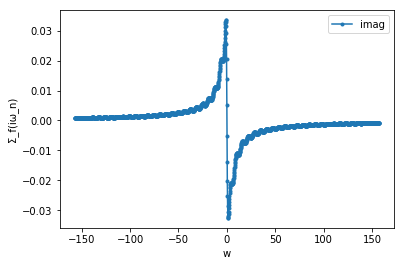

In [88]:
n_tau = 101
beta = 40
tau = np.linspace(0, beta, n_tau)
n_w = np.arange(-1000,1001)
w = np.pi*(2*n_w+1)/beta

#自己無撞着計算の1回分の計算を行う関数を定義

def S_iw_to_S_iw_new(S_iw,U):
    '''
    S_iw_new(S_iw,U)
    S_iw:自己エネルギーΣ_f(iω_n),  U:相互作用の大きさ
    
    '''
    
    #(3)式の積分計算を2重指数関数型積分で行う。
    
    h = 1/200                  #刻み幅
    K = np.arange(-1000,1001)  #和の打ち切り範囲
    G_matrix = 1/(np.fromfunction(lambda n,k:1j*w[n]-2*np.tanh(np.pi/2*np.sinh(K[k]*h)), \
                                  (len(w),len(K)),dtype = int) - S_iw)
    w_vector=np.cosh(K*h)/((np.cosh(np.pi/2*np.sinh(K*h)))**3)
    G_iw = h*np.dot(G_matrix,w_vector)
    
    assert G_iw.shape == (len(w),)
    
    #(1)式を用いてg(iω_n)を導く。
    
    g_iw = 1/(1/G_iw + S_iw)
    
    assert g_iw.shape == (len(w),)
    
    #フーリエ級数をとってg(iω_n)⇒g(τ)に。
    
    exp_matrix = np.fromfunction(lambda t,n : np.exp(-1j*w[n]*tau[t]), (n_tau, len(w)),dtype=int )
    g_tau = (1/beta)*np.dot(exp_matrix, g_iw-1/(1j*w)) - 1/2
    
    assert g_tau.shape == (n_tau,)
    
    #(4)式によりΣ_f(τ)を導く。
    
    S_tau = (U**2)*(g_tau**2)*(g_tau[::-1])
    
    #Σ(τ)を3次スプライン補間
    
    S_tau_func = interp1d(tau, S_tau, kind="cubic")
    
    #Σ(τ)を（台形則による）フーリエ変換でΣ_f(iω_n)へ
    
    N = 10001 #分割数
    tau_new = np.delete(np.linspace(1, beta, N),N-1)
    S = S_tau_func(tau_new)
    exp_matrix = np.fromfunction(lambda n,t : np.exp(1j*w[n]*tau_new[t]), (len(w), N-1),dtype=int )
    S_iw_new = beta/(N-1)*np.dot(exp_matrix, S)
    
    assert S_iw_new.shape == (len(w),)
    
    return S_iw_new
    
    

#自己無撞着計算をする関数を定義。

def recur(U,k=0) :
    '''
    recur(U,k=0)
    U:相互作用,  k:混ざり具合(0≦k≦1)
    
    '''
    
    #Σ_f(iω_n)をゼロに初期化。
    
    S_iw = np.zeros_like(w)
    
    for i in range(100) :  #ループ回数の上限を100回とする。
        
        S_iw_new = (1-k)*S_iw_to_S_iw_new(S_iw,U) + k*S_iw
        
        #ループ5回以上、かつすべての要素の誤差が閾値以下ならループを抜け出す。
        
        if i>5 and np.all(abs( (S_iw_new-S_iw).imag/max(S_iw_new).imag ) < 0.001 )  :
            print('ループ回数 :',i+1)
            return S_iw_new
            break
        
        S_iw = S_iw_new
        
    else :
        print('収束せず')
        return S_iw_new
       
        
S_iw_U1 = recur(U=1)

plt.plot(w, S_iw_U1.imag, label='imag', marker='.')
plt.xlabel('w')
plt.ylabel('Σ_f(iω_n)')
plt.legend()
plt.show()

ループ回数 : 11
収束せず
収束せず
ループ回数 : 30
収束せず


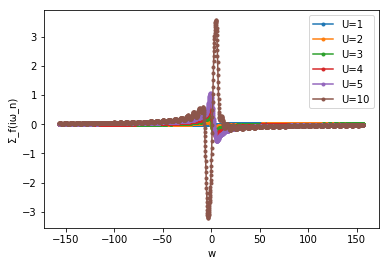

In [89]:
S_iw_matrix = S_iw_U1

# U=2からU=6の場合も計算

for u in range(2,6) :
    S_iw_matrix = np.vstack( (S_iw_matrix , recur(U=u,k=0.3)) )

# U=10の場合も計算

S_iw_matrix = np.vstack( (S_iw_matrix,recur(U=10)) )

plt.plot(w, S_iw_matrix.imag[0,:], label='U=1', marker='.')
plt.plot(w, S_iw_matrix.imag[1,:], label='U=2', marker='.')
plt.plot(w, S_iw_matrix.imag[2,:], label='U=3', marker='.')
plt.plot(w, S_iw_matrix.imag[3,:], label='U=4', marker='.')
plt.plot(w, S_iw_matrix.imag[4,:], label='U=5', marker='.')
plt.plot(w, S_iw_matrix.imag[5,:], label='U=10', marker='.')
plt.xlabel('w')
plt.ylabel('Σ_f(iω_n)')
plt.legend()
plt.show()

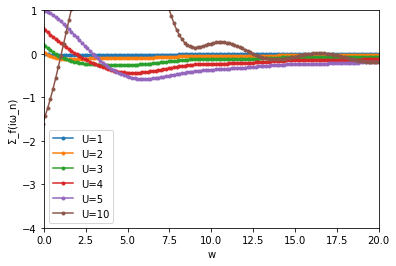

In [90]:
# w>0 

plt.plot(w, S_iw_matrix.imag[0,:], label='U=1', marker='.')
plt.plot(w, S_iw_matrix.imag[1,:], label='U=2', marker='.')
plt.plot(w, S_iw_matrix.imag[2,:], label='U=3', marker='.')
plt.plot(w, S_iw_matrix.imag[3,:], label='U=4', marker='.')
plt.plot(w, S_iw_matrix.imag[4,:], label='U=5', marker='.')
plt.plot(w, S_iw_matrix.imag[5,:], label='U=10', marker='.')
plt.xlabel('w')
plt.ylabel('Σ_f(iω_n)')
plt.xlim([0,20])
plt.ylim([-4,1])
plt.legend()
plt.show()

In [ ]:
U = np.array([1,2,3,4,5,10])
w_0 = np.pi/beta
z = 1/(1 - S_iw_matrix[:,1001:1002].imag/w_0)
print(w_0)
print(z)
plt.plot(U,z,marker=".") 
plt.xlabel("U")
plt.ylabel("z")
plt.show()